### 🧠 Plant Image Classifier Training Pipeline (Google Colab)

This notebook trains a **deep learning model using EfficientNetB0** to classify plant images into different types — all executed in **Google Colab** to leverage **free GPU acceleration** for faster training.

#### 🔧 Key Steps:

1. **Mount Google Drive** to access the dataset and save model artifacts.
2. **Unzip the dataset** if it's not already extracted.
3. Define **data directories** for training and validation images.
4. Use **ImageDataGenerator** to load and augment training data (e.g., rotation, zoom, flips).
5. Save the **class indices mapping** (`class_indices.json`) — used later to correctly decode predictions.
6. Load the **EfficientNetB0** model pre-trained on ImageNet, and fine-tune it on the plant dataset.
7. Add a **Global Average Pooling layer**, **Dropout** for regularization, and a **softmax output layer** for classification.
8. Compile the model using **Adam optimizer** and multiple metrics (accuracy, AUC, precision, recall).
9. Add **callbacks** for early stopping and model checkpointing (best model saved automatically).
10. Train the model and save both:
    - The best model to Google Drive
    - The training history as a JSON file for future visualization

The final model achieves **~97% accuracy** and is later used in a Gradio-based image classification app.

---

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from zipfile import ZipFile
import json

from google.colab import drive
drive.mount('/content/drive')

if not os.path.exists('/content/data/'):
    with ZipFile('/content/drive/MyDrive/Colab Notebooks/Plant Image/data.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    print("Dataset unzipped.")

train_dir = '/content/data/split_ttv_dataset_type_of_plants/Train_Set_Folder'
val_dir = '/content/data/split_ttv_dataset_type_of_plants/Validation_Set_Folder'


print("Extracted folders:", os.listdir('/content/data/'))
print("Train folder contents:", os.listdir(train_dir))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

class_indices_path = '/content/drive/MyDrive/Colab Notebooks/Plant Image/class_indices.json'

with open(class_indices_path, 'w') as f:
    json.dump(train_gen.class_indices, f)
print(f"Class indices saved to {class_indices_path}")

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

base_model = EfficientNetB0(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Plant Image/plant_identifier_efficientnetb0.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

history_path = '/content/drive/MyDrive/Colab Notebooks/Plant Image/history.json'

with open(history_path, 'w') as f:
    json.dump(history.history, f)

print(f"Training history saved to {history_path}")


Mounted at /content/drive
Dataset unzipped.
Extracted folders: ['split_ttv_dataset_type_of_plants']
Train folder contents: ['cucumber', 'pomelo', 'ginger', 'watermelon', 'corn', 'orange', 'pineapple', 'eggplant', 'waterapple', 'longbeans', 'sweet potatoes', 'curcuma', 'coconut', 'melon', 'paddy', 'spinach', 'tobacco', 'galangal', 'peper chili', 'shallot', 'bilimbi', 'soybeans', 'banana', 'guava', 'mango', 'aloevera', 'papaya', 'cantaloupe', 'kale', 'cassava']
Num GPUs Available:  1
Found 23972 images belonging to 30 classes.
Class indices saved to /content/drive/MyDrive/Colab Notebooks/Plant Image/class_indices.json
Found 3030 images belonging to 30 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 469s 516ms/step - accuracy: 0.0746 - auc: 0.5919 - loss: 3.3689 - precision: 0.2489 - recall: 8.3919e-05 - val_accuracy: 0.3545 - val_auc: 0.8670 - val_loss: 2.7077 - val_precision: 0.8889 - val_recall: 0.0026
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 348s 464ms/step - accuracy: 0.3355 - auc: 0.8627 - loss: 2.5583 - precision: 0.8569 - recall: 0.0220 - val_accuracy: 0.6172 - val_auc: 0.9617 - val_loss: 1.7672 - val_precision: 0.9549 - val_recall: 0.1257
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 348s 464ms/step - accuracy: 0.5610 - auc: 0.9505 - loss: 1.7345 - precision: 0.8979 - recall: 0.1733 - val_accuracy: 0.6568 - val_auc: 0.9714 - val_loss: 1.4614 - val_precision: 0.9317 - val_recall: 0.2568
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 375s 454ms/step - accuracy: 0.6804 - auc: 0.9756 - loss: 1.2247 - precision: 0.8963 - recall: 0.3945 - val_accuracy: 0.7627 - val_auc: 0.9883 - val_loss: 0.9170 - val_precision: 0.9365 - val_recall: 0.5452
Epoch 5/30
7

### 📈 Visualizing Training Performance

This cell loads the saved training history from the model (stored as a JSON file) and plots two important metrics:

- **Accuracy Curve**: Shows how the model's training and validation accuracy evolved over epochs.
- **Loss Curve**: Shows how the training and validation loss changed over time.

These visualizations help assess whether the model is:
- **Learning effectively** (increasing accuracy, decreasing loss)
- **Overfitting or underfitting** (e.g., large gap between training and validation performance)

This step is crucial to ensure that the model generalizes well and wasn't just memorizing the training data.

---

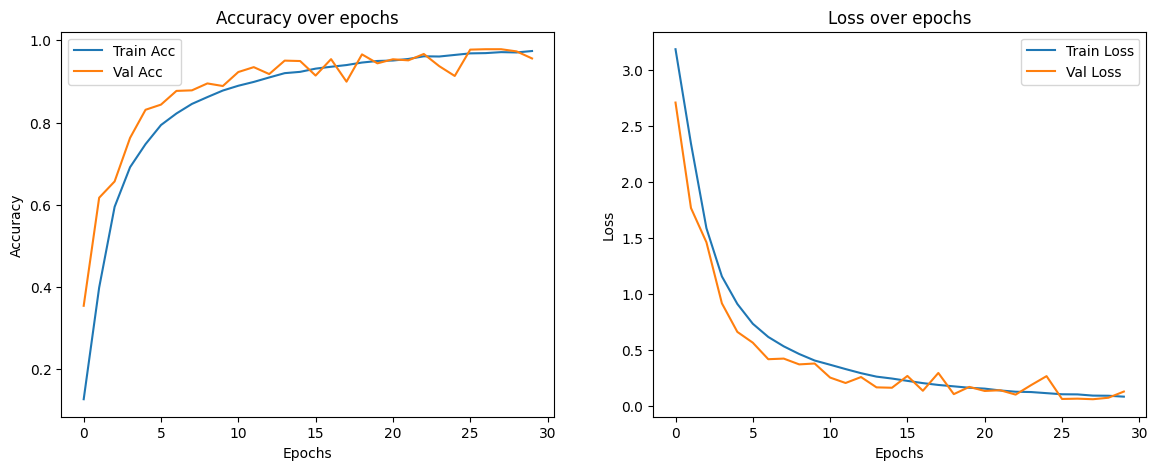

In [ ]:
import json
import matplotlib.pyplot as plt

history_path = '/content/drive/MyDrive/Colab Notebooks/Plant Image/history.json'

with open(history_path, 'r') as f:
    history = json.load(f)

# Plotting
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### 📊 Model Evaluation on Test Set

This section evaluates the **final trained plant classifier** on a **separate test dataset** to measure its generalization performance.

#### What this code does:

1. **Mounts Google Drive** to access the saved model and dataset.
2. **Unzips the dataset** (if not already extracted).
3. Loads the **saved `class_indices.json`** file to correctly interpret class predictions.
4. Prepares the **test data generator** using `ImageDataGenerator` with only rescaling.
5. Loads the **best performing model** (`.keras` format) saved during training.
6. Runs `model.evaluate()` to get basic loss and accuracy metrics on the test set.
7. Makes predictions on the test images and converts logits into class labels.
8. Prints a **detailed classification report** (precision, recall, F1-score for each class).
9. Plots a **confusion matrix** using Seaborn to visualize which plant types the model confuses most often.

This evaluation ensures the model performs well on completely unseen data and helps identify specific classes where performance can be improved.

---

Mounted at /content/drive
Dataset unzipped.
Found 2998 images belonging to 30 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.9772 - auc: 0.9998 - loss: 0.0617 - precision: 0.9819 - recall: 0.9740
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step
                precision    recall  f1-score   support

      aloevera       0.98      1.00      0.99       100
        banana       1.00      0.97      0.98       100
       bilimbi       1.00      0.99      0.99       100
    cantaloupe       0.86      0.88      0.87       100
       cassava       1.00      1.00      1.00       100
       coconut       0.98      1.00      0.99       100
          corn       1.00      0.99      0.99       100
      cucumber       1.00      0.96      0.98        99
       curcuma       1.00      0.97      0.98       100
      eggplant       1.00      1.00      1.00       100
      galangal       0.98      0.99      0.99       100
        ginger       0.97      0.99      0.98       100
         guava       1.00      0.98      0.99       100
          kale       0.97      0.96      0.96 

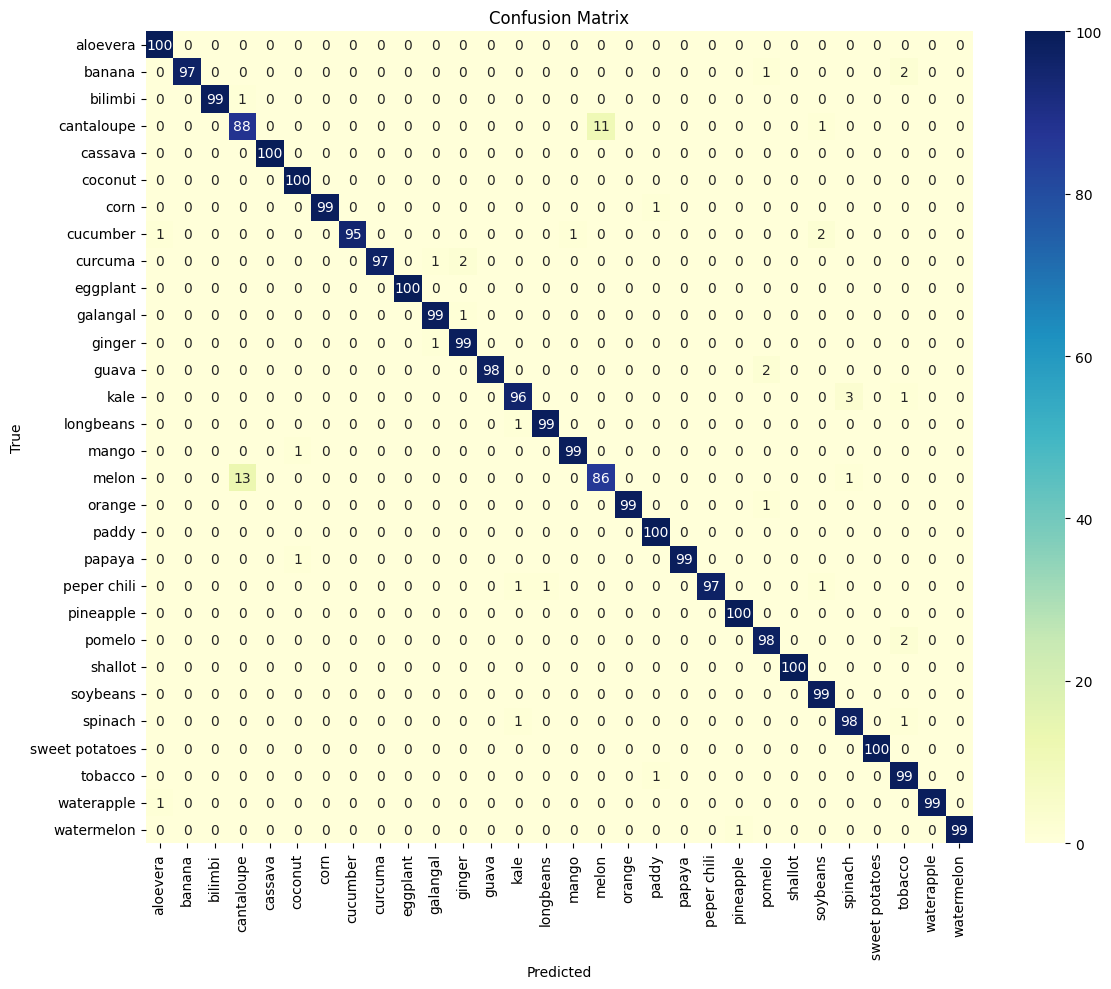

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import os
import json
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/drive')

if not os.path.exists('/content/data/'):
    with ZipFile('/content/drive/MyDrive/Colab Notebooks/Plant Image/data.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    print("Dataset unzipped.")

with open('/content/drive/MyDrive/Colab Notebooks/Plant Image/class_indices.json', 'r') as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}

test_dir = '/content/data/split_ttv_dataset_type_of_plants/Test_Set_Folder'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=list(class_indices.keys())
)

best_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Plant Image/plant_identifier_efficientnetb0.keras')

best_model.evaluate(test_gen)

y_pred = best_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
